# GANs: Latent Space Exploration and Image Generation

A comprehensive exploration of Generative Adversarial Networks (GANs) including latent space interpolation and vector arithmetic operations.

# Part 1: GANs with Latent Space Exploration

In this project, we implement a Generative Adversarial Network (GAN) to:
- Generate realistic images of handwritten digits from the MNIST dataset
- Explore latent space interpolation to understand smooth transitions between digits
- Perform vector arithmetic in the latent space to discover meaningful feature combinations
- Apply these concepts to the pre-trained CelebA face generator

This exploration reveals the power of GANs to learn meaningful, manipulable representations of complex data.

### Imports

In [2]:
# ============ Import stuff here =============
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
# ===== you may include more helper libs ======
# ===== (just don't include an entire =========
# ===== generator/discriminator - that ========
# ===== you've to make from scratch) ==========

from sklearn.model_selection import train_test_split

### Load the MNIST thing

### Data Loading and Preparation

In this section, we:
- Load the MNIST dataset
- Apply necessary transformations and preprocessing
- Define train-test splits
- Set up data loaders for efficient batching
- Visualize sample digits to understand the data

Train Size: 60000
Test Size: 10000
Train-test Train split: 0.8571428571428571
Train-test Test split: 0.14285714285714285


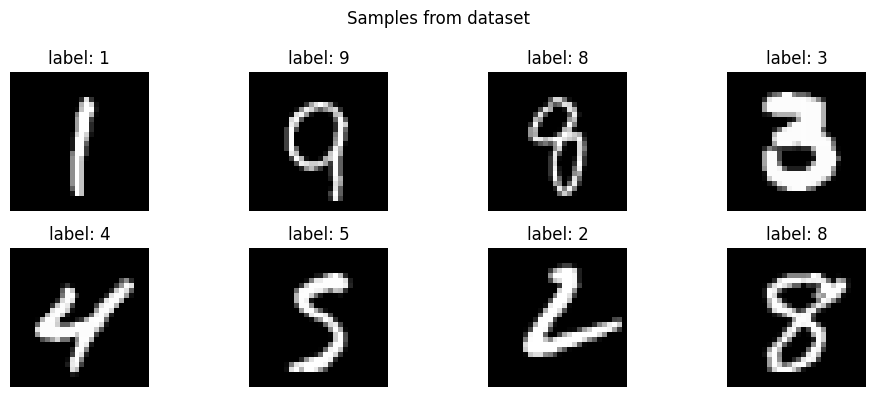

In [20]:
# Code here
BATCH_SIZE = 64
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

train_dataset = datasets.MNIST(root='./', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)


print(f"Train Size: {len(train_dataset)}")
print(f"Test Size: {len(test_dataset)}")
print(f'Train-test Train split: {len(train_dataset) / (len(train_dataset) + len(test_dataset)) }')
print(f'Train-test Test split: {len(test_dataset) / (len(train_dataset) + len(test_dataset)) }')

samples = next(iter(train_loader))
images, labels = samples

plt.figure(figsize=(10,4))
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(images[i].squeeze(), cmap='gray')
    plt.title(f'label: {labels[i].item()}')
    plt.axis('off')
plt.suptitle('Samples from dataset')
plt.tight_layout()
plt.show()



## Building the GAN Architecture

GANs consist of two neural networks that compete with each other in a game-theoretic framework:

**Generator (G):** Takes a random noise vector ($z$) as input and generates synthetic images $G(z)$ that aim to resemble real data.

**Discriminator (D):** Acts as a binary classifier that distinguishes between real images (from the dataset) and fake images (generated by G).

### The Adversarial Process

The two networks engage in a minimax game:
- The **Generator** tries to fool the discriminator by creating increasingly realistic images
- The **Discriminator** improves its ability to detect fakes

This adversarial process drives both networks to improve, ultimately resulting in a generator that can produce highly realistic synthetic images.

In [21]:
# Code the Generator here
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512,1024),
            nn.ReLU(True),
            nn.Linear(1024, 28*28),
            nn.Tanh()
        )
        
    def forward(self, x):
        x = self.model(x)
        x = x.view(x.size(0), 1 , 28, 28)
        return x

In [22]:
# Code the Discriminator here
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
            
        )
              

    def forward(self, x):
        return self.model(x)

In [23]:
# initializing the instances of the Generator and Discriminator respectively
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = Generator().to(device)
discriminator = Discriminator().to(device)

### Losses and optimizers

In [24]:
# Loss 
criterion = nn.BCELoss()

# Optimizers
optimizer_g = optim.Adam(generator.parameters(), lr=0.0002)
optimizer_d = optim.Adam(discriminator.parameters(), lr=0.0002)

## Training the GAN

The training process alternates between updating the discriminator and the generator. Each epoch involves:

1. **Prepare data**: Create batches of real and fake images
2. **Train discriminator on real data**: Compute real loss
3. **Train discriminator on fake data**: Compute fake loss
4. **Train generator**: Compute generator loss and update to fool the discriminator

### Loss Functions Explained

**Discriminator Loss:**
The discriminator aims to correctly classify real and fake images:
- Real Loss: $E_{x}\log(D(x))$ - Measures classification accuracy on real images
- Fake Loss: $E_{z}\log(1-D(G(z)))$ - Measures detection of fake images
- Total: $L_{D} = \text{real loss} + \text{fake loss}$

**Generator Loss:**
The generator tries to maximize the probability that the discriminator misclassifies fake images as real:
- $L_{G} = E\log(D(G(z)))$

**Discriminator** 
The discriminator is trained to distinguish between real and fake images (binary classification). It aims to correctly classify real images as real and generated images as fake. It has two components:
- Real Loss: Measures how well the discriminator classifies real images correctly.
- Fake Loss: Measures how well the discriminator identifies fake images. <br> <br>
The total discriminator loss is given by: <br>
$ L_{D} =$ real loss $+$ fake loss <br>
where <br>
real loss $= E_{x}\log(D(x))$ <br>
fake loss $= E_{z}\log(1-D(G(z)))$


**Generator** 
The generator tries to fool the discriminator by generating images that D misclassifies as real. Instead of minimizing the difference between generated and real images directly, G is trained to maximize the likelihood that $D$ assigns high probability to fake images (so it'll only have the maximizing portion) <br><br>
$ L_{G} = E\log(D(G(z)))$  <br>

Epoch [1/50] - Loss D: 0.9733, Loss G: 1.5291
Epoch [2/50] - Loss D: 0.9951, Loss G: 1.4887
Epoch [3/50] - Loss D: 1.0077, Loss G: 1.4522
Epoch [4/50] - Loss D: 1.0082, Loss G: 1.4596
Epoch [5/50] - Loss D: 1.0234, Loss G: 1.4488


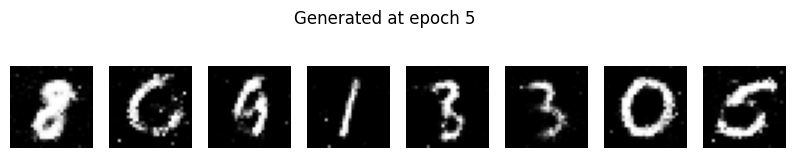

Epoch [6/50] - Loss D: 1.0298, Loss G: 1.4287
Epoch [7/50] - Loss D: 1.0375, Loss G: 1.4002
Epoch [8/50] - Loss D: 1.0519, Loss G: 1.3680
Epoch [9/50] - Loss D: 1.0477, Loss G: 1.3545
Epoch [10/50] - Loss D: 1.0606, Loss G: 1.3349


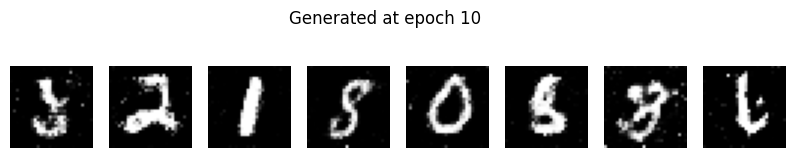

Epoch [11/50] - Loss D: 1.0597, Loss G: 1.3325
Epoch [12/50] - Loss D: 1.0783, Loss G: 1.3045
Epoch [13/50] - Loss D: 1.0747, Loss G: 1.3080
Epoch [14/50] - Loss D: 1.0880, Loss G: 1.2989
Epoch [15/50] - Loss D: 1.0930, Loss G: 1.2459


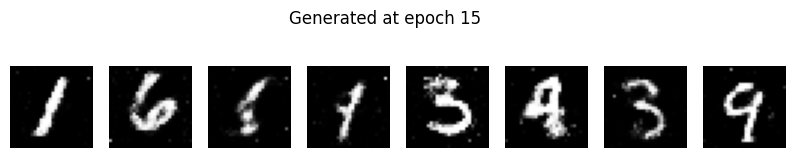

Epoch [16/50] - Loss D: 1.0880, Loss G: 1.2803
Epoch [17/50] - Loss D: 1.0779, Loss G: 1.3025
Epoch [18/50] - Loss D: 1.0977, Loss G: 1.2597
Epoch [19/50] - Loss D: 1.0959, Loss G: 1.2622
Epoch [20/50] - Loss D: 1.0971, Loss G: 1.2432


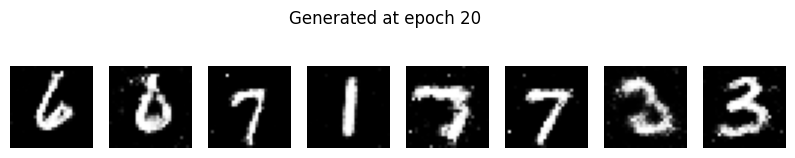

Epoch [21/50] - Loss D: 1.0970, Loss G: 1.2585
Epoch [22/50] - Loss D: 1.1119, Loss G: 1.2328
Epoch [23/50] - Loss D: 1.1064, Loss G: 1.2294
Epoch [24/50] - Loss D: 1.1224, Loss G: 1.1802
Epoch [25/50] - Loss D: 1.1238, Loss G: 1.2014


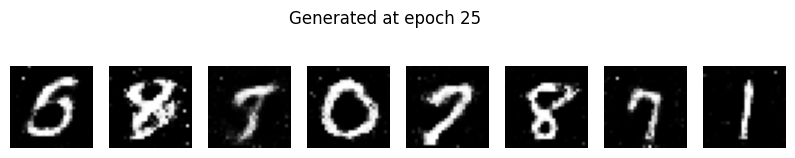

Epoch [26/50] - Loss D: 1.1252, Loss G: 1.2046
Epoch [27/50] - Loss D: 1.1265, Loss G: 1.2045
Epoch [28/50] - Loss D: 1.1256, Loss G: 1.2081
Epoch [29/50] - Loss D: 1.1336, Loss G: 1.1759
Epoch [30/50] - Loss D: 1.1297, Loss G: 1.1811


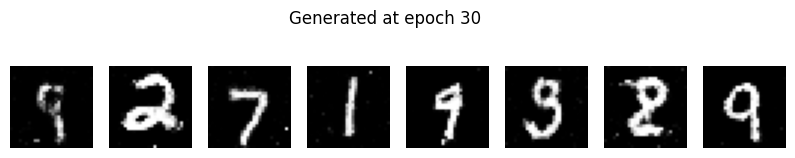

Epoch [31/50] - Loss D: 1.1443, Loss G: 1.1738
Epoch [32/50] - Loss D: 1.1414, Loss G: 1.1500
Epoch [33/50] - Loss D: 1.1501, Loss G: 1.1492
Epoch [34/50] - Loss D: 1.1551, Loss G: 1.1225
Epoch [35/50] - Loss D: 1.1631, Loss G: 1.1449


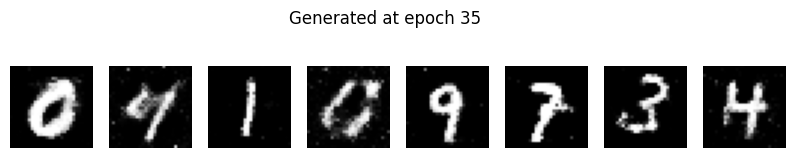

Epoch [36/50] - Loss D: 1.1620, Loss G: 1.1074
Epoch [37/50] - Loss D: 1.1604, Loss G: 1.1183
Epoch [38/50] - Loss D: 1.1661, Loss G: 1.1310
Epoch [39/50] - Loss D: 1.1674, Loss G: 1.1061
Epoch [40/50] - Loss D: 1.1695, Loss G: 1.0947


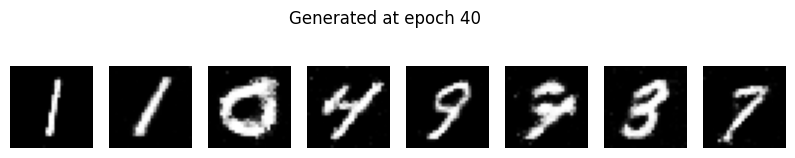

Epoch [41/50] - Loss D: 1.1773, Loss G: 1.0921
Epoch [42/50] - Loss D: 1.1833, Loss G: 1.0712
Epoch [43/50] - Loss D: 1.1802, Loss G: 1.0804
Epoch [44/50] - Loss D: 1.1786, Loss G: 1.0885
Epoch [45/50] - Loss D: 1.1899, Loss G: 1.0546


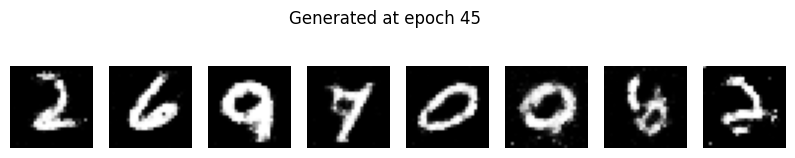

Epoch [46/50] - Loss D: 1.1863, Loss G: 1.0604
Epoch [47/50] - Loss D: 1.1886, Loss G: 1.0645
Epoch [48/50] - Loss D: 1.1856, Loss G: 1.0659
Epoch [49/50] - Loss D: 1.1854, Loss G: 1.0619
Epoch [50/50] - Loss D: 1.1899, Loss G: 1.0543


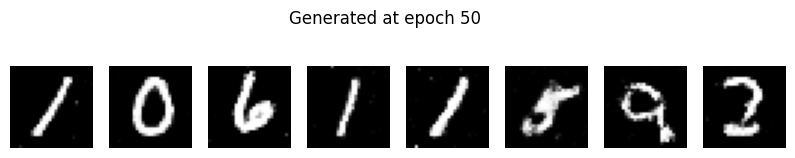

In [29]:
epochs = 50


# Training Loop

gen_losses = []
disc_losses = []
best_g_loss = float('inf')
best_generator_state = None
best_discriminator_state = None

for epoch in range(epochs):
    total_d_epoch_loss = 0.0
    total_g_epoch_loss = 0.0

    for batch_index, (real_images, _) in enumerate(train_loader):
        batch_size = real_images.size(0)
        real_images = real_images.to(device)

        real_labels = torch.ones(batch_size,1).to(device)
        fake_labels = torch.zeros(batch_size,1).to(device)

        outputs = discriminator(real_images)
        real_loss_d = criterion(outputs, real_labels)

        z = torch.randn(batch_size, 100).to(device)
        fake_image = generator(z)

        outputs = discriminator(fake_image.detach())
        fake_loss_d = criterion(outputs, fake_labels)

        total_loss_d = real_loss_d + fake_loss_d

        optimizer_d.zero_grad()
        total_loss_d.backward()
        total_d_epoch_loss += total_loss_d.item()

        optimizer_d.step()

        z = torch.randn(batch_size, 100).to(device)
        fake_image = generator(z)

        outputs = discriminator(fake_image)
        loss_g = criterion(outputs, real_labels)

        optimizer_g.zero_grad()
        loss_g.backward()
        total_g_epoch_loss += loss_g.item()
        optimizer_g.step()
    
    avg_d_loss = total_d_epoch_loss / len(train_loader)
    avg_g_loss = total_g_epoch_loss / len(train_loader)
    gen_losses.append(avg_g_loss)
    disc_losses.append(avg_d_loss)

    print(f"Epoch [{epoch+1}/{epochs}] - Loss D: {avg_d_loss:.4f}, Loss G: {avg_g_loss:.4f}")

    if avg_g_loss < best_g_loss:
        best_g_loss = avg_g_loss
        best_generator_state = generator.state_dict()
        best_discriminator_state = discriminator.state_dict()
        torch.save(best_generator_state, '26100342_gen.pth')
        torch.save(best_discriminator_state, '26100342_disc.pth')
        
    if (epoch + 1) % 5 == 0:
        with torch.no_grad():
            z = torch.randn(8, 100).to(device)
            generated_images = generator(z).cpu()

        plt.figure(figsize=(10, 2))
        for i in range(8):
            plt.subplot(1, 8, i + 1)
            plt.imshow(generated_images[i].squeeze(), cmap='gray')
            plt.axis('off')
        plt.suptitle(f"Generated at epoch {epoch+1}")
        plt.show()
        


### Training Analysis

Here we:
1. Save the best performing generator and discriminator models
2. Plot training curves for both generator and discriminator losses
3. Visualize samples from the best generator to assess quality

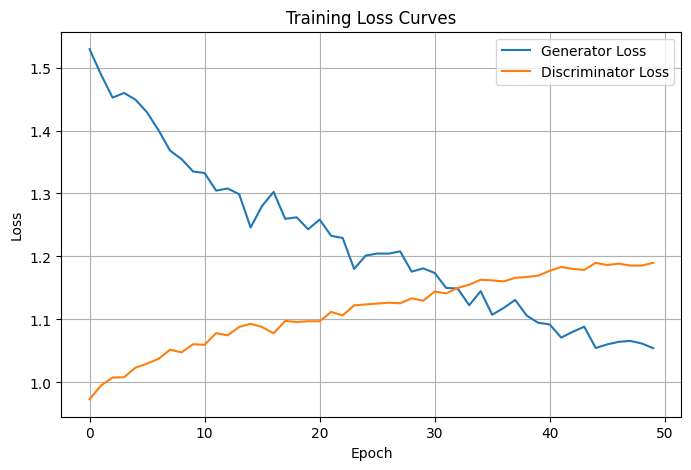

<ipython-input-68-b5b42260d79b>:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_gen.load_state_dict(torch.load('26100342_gen.pth'))


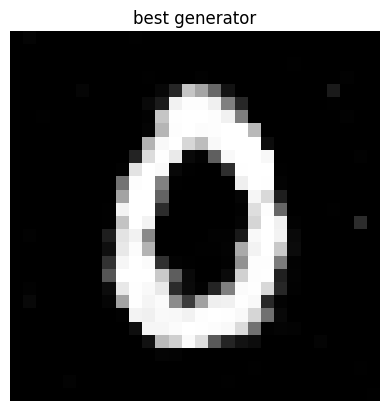

In [68]:
# code

plt.figure(figsize=(8, 5))
plt.plot(gen_losses, label='Generator Loss')
plt.plot(disc_losses, label='Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curves')
plt.legend()
plt.grid(True)
plt.show()


best_gen = Generator().to(device)
best_gen.load_state_dict(torch.load('26100342_gen.pth'))
best_gen.eval()

with torch.no_grad():
    z = torch.randn(1, 100).to(device)
    best_img = best_gen(z).cpu().squeeze()

plt.imshow(best_img, cmap='gray')
plt.title("best generator")
plt.axis('off')
plt.show()


### Exploring the Latent Space through Interpolation

The latent space is a continuous vector space of all possible inputs to the generator. Since it's a vector space, we can perform operations like interpolation to understand how the generator smoothly transitions between different outputs.

**Key Insight:** By interpolating between two random noise vectors, we can observe how the generator creates intermediate representations, revealing the structure of what it has learned.

**Further Reading:** [Latent Space Interpolation and Vector Arithmetic with GANs](https://machinelearningmastery.com/how-to-interpolate-and-perform-vector-arithmetic-with-faces-using-a-generative-adversarial-network/)

### Implementation Steps:

1. **Define two random noise vectors** of the latent dimension
2. **Generate interpolated images** transitioning from one to the other using:
   
   $$
   \text{interpolation} = \alpha \cdot z_1 + (1-\alpha) \cdot z_2
   $$  

   where $z_{1}$ and $z_{2}$ are two random noise vectors. The result is a series of images showing the generator's smooth transition (e.g., morphing from a digit 3 to a digit 7).

3. **Visualize the interpolation** with at least 10 steps, including start and end points

<ipython-input-63-c6c8de3f9998>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load('26100342_gen.pth'))


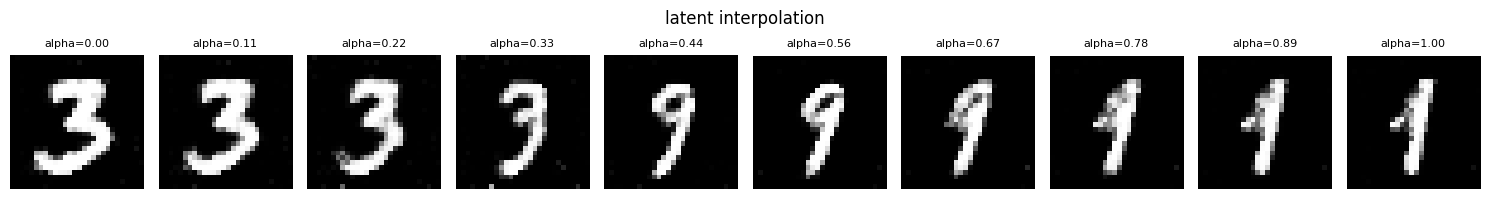

In [63]:
generator = Generator().to(device)
generator.load_state_dict(torch.load('26100342_gen.pth'))
generator.eval()

z1 = torch.randn(1, 100).to(device)
z2 = torch.randn(1, 100).to(device)

interpolated_z = []

steps = 10
alphas = torch.linspace(0, 1, steps).to(device)
for alpha in alphas:
    z = alpha * z1 + (1 - alpha) * z2
    interpolated_z.append(z)

interpolated_z = torch.cat(interpolated_z, dim=0)

with torch.no_grad():
    generated_images = generator(interpolated_z).cpu()

plt.figure(figsize=(15, 2))
for i in range(steps):
    plt.subplot(1, steps, i + 1)
    plt.imshow(generated_images[i].squeeze(), cmap='gray')
    plt.axis('off')
    plt.title(f"alpha={alphas[i]:.2f}", fontsize=8)
plt.suptitle("latent interpolation")
plt.tight_layout()
plt.show()

### Latent Space Interpolation with Pre-trained CelebA GAN

The **CelebA dataset** contains ~200,000 celebrity face images (178×218 pixels). We've provided a pre-trained DCGAN model trained on this dataset, allowing us to explore latent space interpolation with realistic human faces.

**What to expect:** Smooth transitions between different faces, with intermediate steps showing meaningful combinations of facial features (e.g., transitioning from a smiling woman to a neutral man, passing through states like a neutral woman).

**Files needed:**
- `dcgan.py` - Model architecture definition
- `generator.pt` - Pre-trained generator weights

Place these files in the current directory before running the next cells.

In [44]:
# put the dcgan.py file and generator.pt in the current directory and then run this cell
import sys
sys.path.append('/kaggle/input/dcgan-files')
from dcgan import DCGAN
generator_path = "/kaggle/input/dcgan-files/generator.pt"
gan = DCGAN(gan_type="gan", use_cuda=True)
gan.load_model(filename=generator_path, use_cuda=torch.cuda.is_available())
gan.eval()
gan = gan.to(device)
print("Number of parameters in the pre-trained generator:", gan.get_num_params())
gan = gan.cuda()  # Move to GPU if available

Loading generator checkpoint from: /kaggle/input/dcgan-files/generator.pt
Number of parameters in the pre-trained generator: 3592064


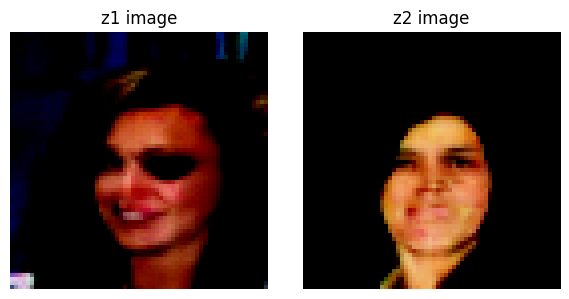

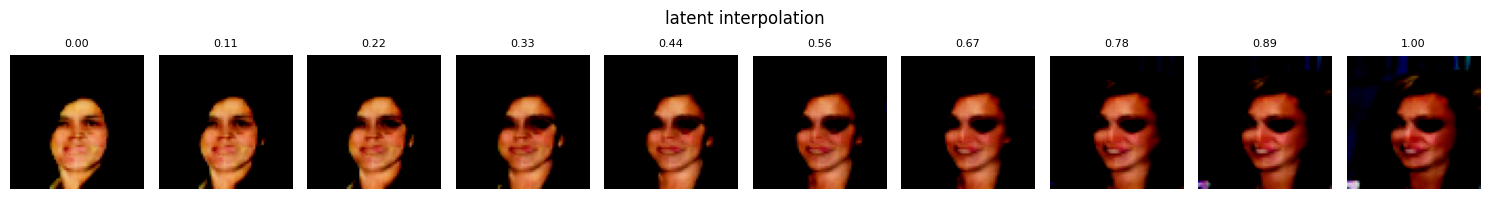

In [ ]:
### CelebA Interpolation Implementation

Steps:
1. Visualize the images generated from z1 and z2 (start and end points)
2. Interpolate from z1 to z2 using the formula above
3. Plot all interpolation steps (minimum 10 steps)
4. Observe how facial features smoothly transition

### Vector Arithmetic in the Latent Space

Since the latent space is a vector space, we can perform arithmetic operations (addition, subtraction, averaging) on latent vectors to discover meaningful feature combinations.

### Understanding Latent Arithmetic

When interpolating between CelebA images, you might notice transitions pass through representations of other facial expressions or genders. This happens because the latent space captures underlying features of the dataset, and interpolation paths can traverse regions where features mix.

**Vector arithmetic extends this concept:** Adding/subtracting latent vectors can produce meaningful blends of features. For example:
- Adding vectors for different ethnicities might generate intermediate appearances
- Subtracting "glasses" from a face might remove eyeglasses
- Averaging multiple faces creates a composite appearance

### Experiment Design

1. Generate two or more images from random noise
2. Perform arithmetic operations on their latent vectors (addition, subtraction, averaging)
3. Generate images from the resulting vectors
4. Display and analyze the results

**Example:**
- $\text{noise}_r = \text{noise}_1 + \text{noise}_2$
- Does $\text{image}_r$ blend features from $\text{image}_1$ and $\text{image}_2$?

Perform at least three different arithmetic operations to explore this phenomenon.

**Note:** Results won't be perfect but should show meaningful feature combinations to some extent.

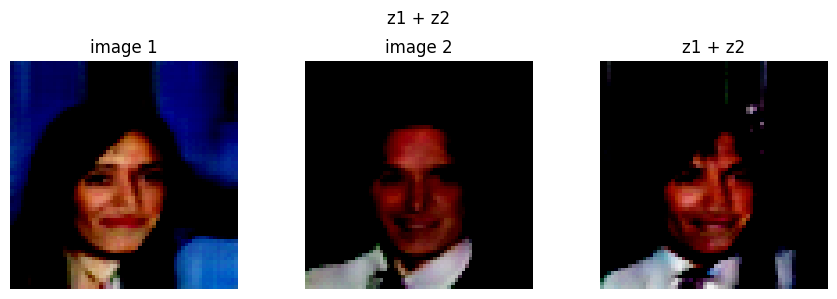

In [56]:
# display random images from the generator, then dispaly there arithmetic.
z1 = torch.randn(1, 100).to(device)
z2 = torch.randn(1, 100).to(device)
z_r = z1 + z2

with torch.no_grad():
    img1 = gan.generate_img(z1).cpu().squeeze()
    img2 = gan.generate_img(z2).cpu().squeeze()
    img_r = gan.generate_img(z_r).cpu().squeeze()

plt.figure(figsize=(9, 3))
plt.subplot(1, 3, 1)
plt.imshow(img1.permute(1, 2, 0), cmap='gray')
plt.title("image 1")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(img2.permute(1, 2, 0), cmap='gray')
plt.title("image 2")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(img_r.permute(1, 2, 0), cmap='gray')
plt.title("z1 + z2")
plt.axis('off')

plt.suptitle("z1 + z2")
plt.tight_layout()
plt.show()


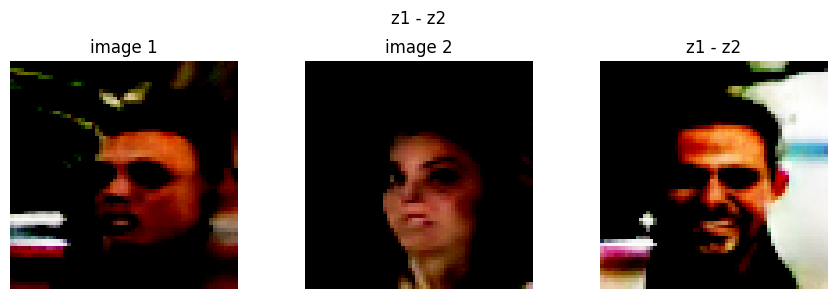

In [62]:
# display random images from the generator, then dispaly there arithmetic.
z1 = torch.randn(1, 100).to(device)
z2 = torch.randn(1, 100).to(device)
z_r = z1 - z2

with torch.no_grad():
    img1 = gan.generate_img(z1).cpu().squeeze()
    img2 = gan.generate_img(z2).cpu().squeeze()
    img_r = gan.generate_img(z_r).cpu().squeeze()

plt.figure(figsize=(9, 3))
plt.subplot(1, 3, 1)
plt.imshow(img1.permute(1, 2, 0), cmap='gray')
plt.title("image 1")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(img2.permute(1, 2, 0), cmap='gray')
plt.title("image 2")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(img_r.permute(1, 2, 0), cmap='gray')
plt.title("z1 - z2")
plt.axis('off')

plt.suptitle("z1 - z2")
plt.tight_layout()
plt.show()


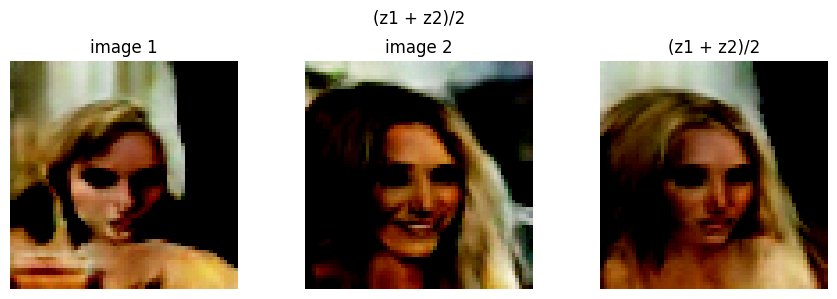

In [51]:
# display random images from the generator, then dispaly there arithmetic.
z1 = torch.randn(1, 100).to(device)
z2 = torch.randn(1, 100).to(device)
z_r = (z1 + z2) / 2

with torch.no_grad():
    img1 = gan.generate_img(z1).cpu().squeeze()
    img2 = gan.generate_img(z2).cpu().squeeze()
    img_r = gan.generate_img(z_r).cpu().squeeze()

plt.figure(figsize=(9, 3))
plt.subplot(1, 3, 1)
plt.imshow(img1.permute(1, 2, 0), cmap='gray')
plt.title("image 1")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(img2.permute(1, 2, 0), cmap='gray')
plt.title("image 2")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(img_r.permute(1, 2, 0), cmap='gray')
plt.title("(z1 + z2)/2")
plt.axis('off')

plt.suptitle("(z1 + z2)/2")
plt.tight_layout()
plt.show()


## Analysis Questions

### Question 1: Understanding GAN Artifacts

**Q: Some generated images appear distorted or unrealistic. What major problems do GANs have that cause these distortions?**

**Answer:**
- **Mode collapse**: GANs produce limited variations when they fall into mode collapse, generating similar outputs repeatedly
- **Training instability**: The adversarial training process can be unstable due to the competing objectives of generator and discriminator
- **Vanishing gradients**: When the discriminator becomes too powerful, it provides little useful gradient signal to the generator, causing learning to stall
- **Lack of explicit density modeling**: Unlike VAEs, GANs don't model the data distribution explicitly, which can lead to missing modes or unrealistic samples

### Further Reading

For insights into how modern diffusion models address some of GAN's limitations and achieve more realistic image generation, see: [GANs vs Diffusion Models](https://aurorasolar.com/blog/putting-ai-to-the-test-generative-adversarial-networks-vs-diffusion-models/)

---

## Project Summary

### What We Achieved

Through this project, we:

- ✅ Implemented a complete GAN architecture with generator and discriminator
- ✅ Trained the model on MNIST to generate realistic handwritten digits
- ✅ Explored latent space interpolation to understand smooth feature transitions
- ✅ Performed vector arithmetic in latent space to discover feature combinations
- ✅ Applied these concepts to a pre-trained CelebA face generator
- ✅ Analyzed the limitations and challenges of GANs

### Key Insights

**The Power of Latent Spaces:**
- Latent spaces in GANs are continuous and structured
- Interpolation reveals smooth transitions between generated samples
- Vector arithmetic can combine features in meaningful ways

**Practical Understanding:**
- GANs learn implicit representations of data distributions
- The adversarial training process is powerful but can be unstable
- Trade-offs exist between sample quality, diversity, and training stability

This exploration demonstrates how GANs can learn rich, manipulable representations of complex data, paving the way for applications in image synthesis, style transfer, and data augmentation.